# Using OCR Bounding Boxes and Images to evaluate text confidence

In [198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Corrupt JPEG data: bad Huffman code
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_6547/2595608299.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


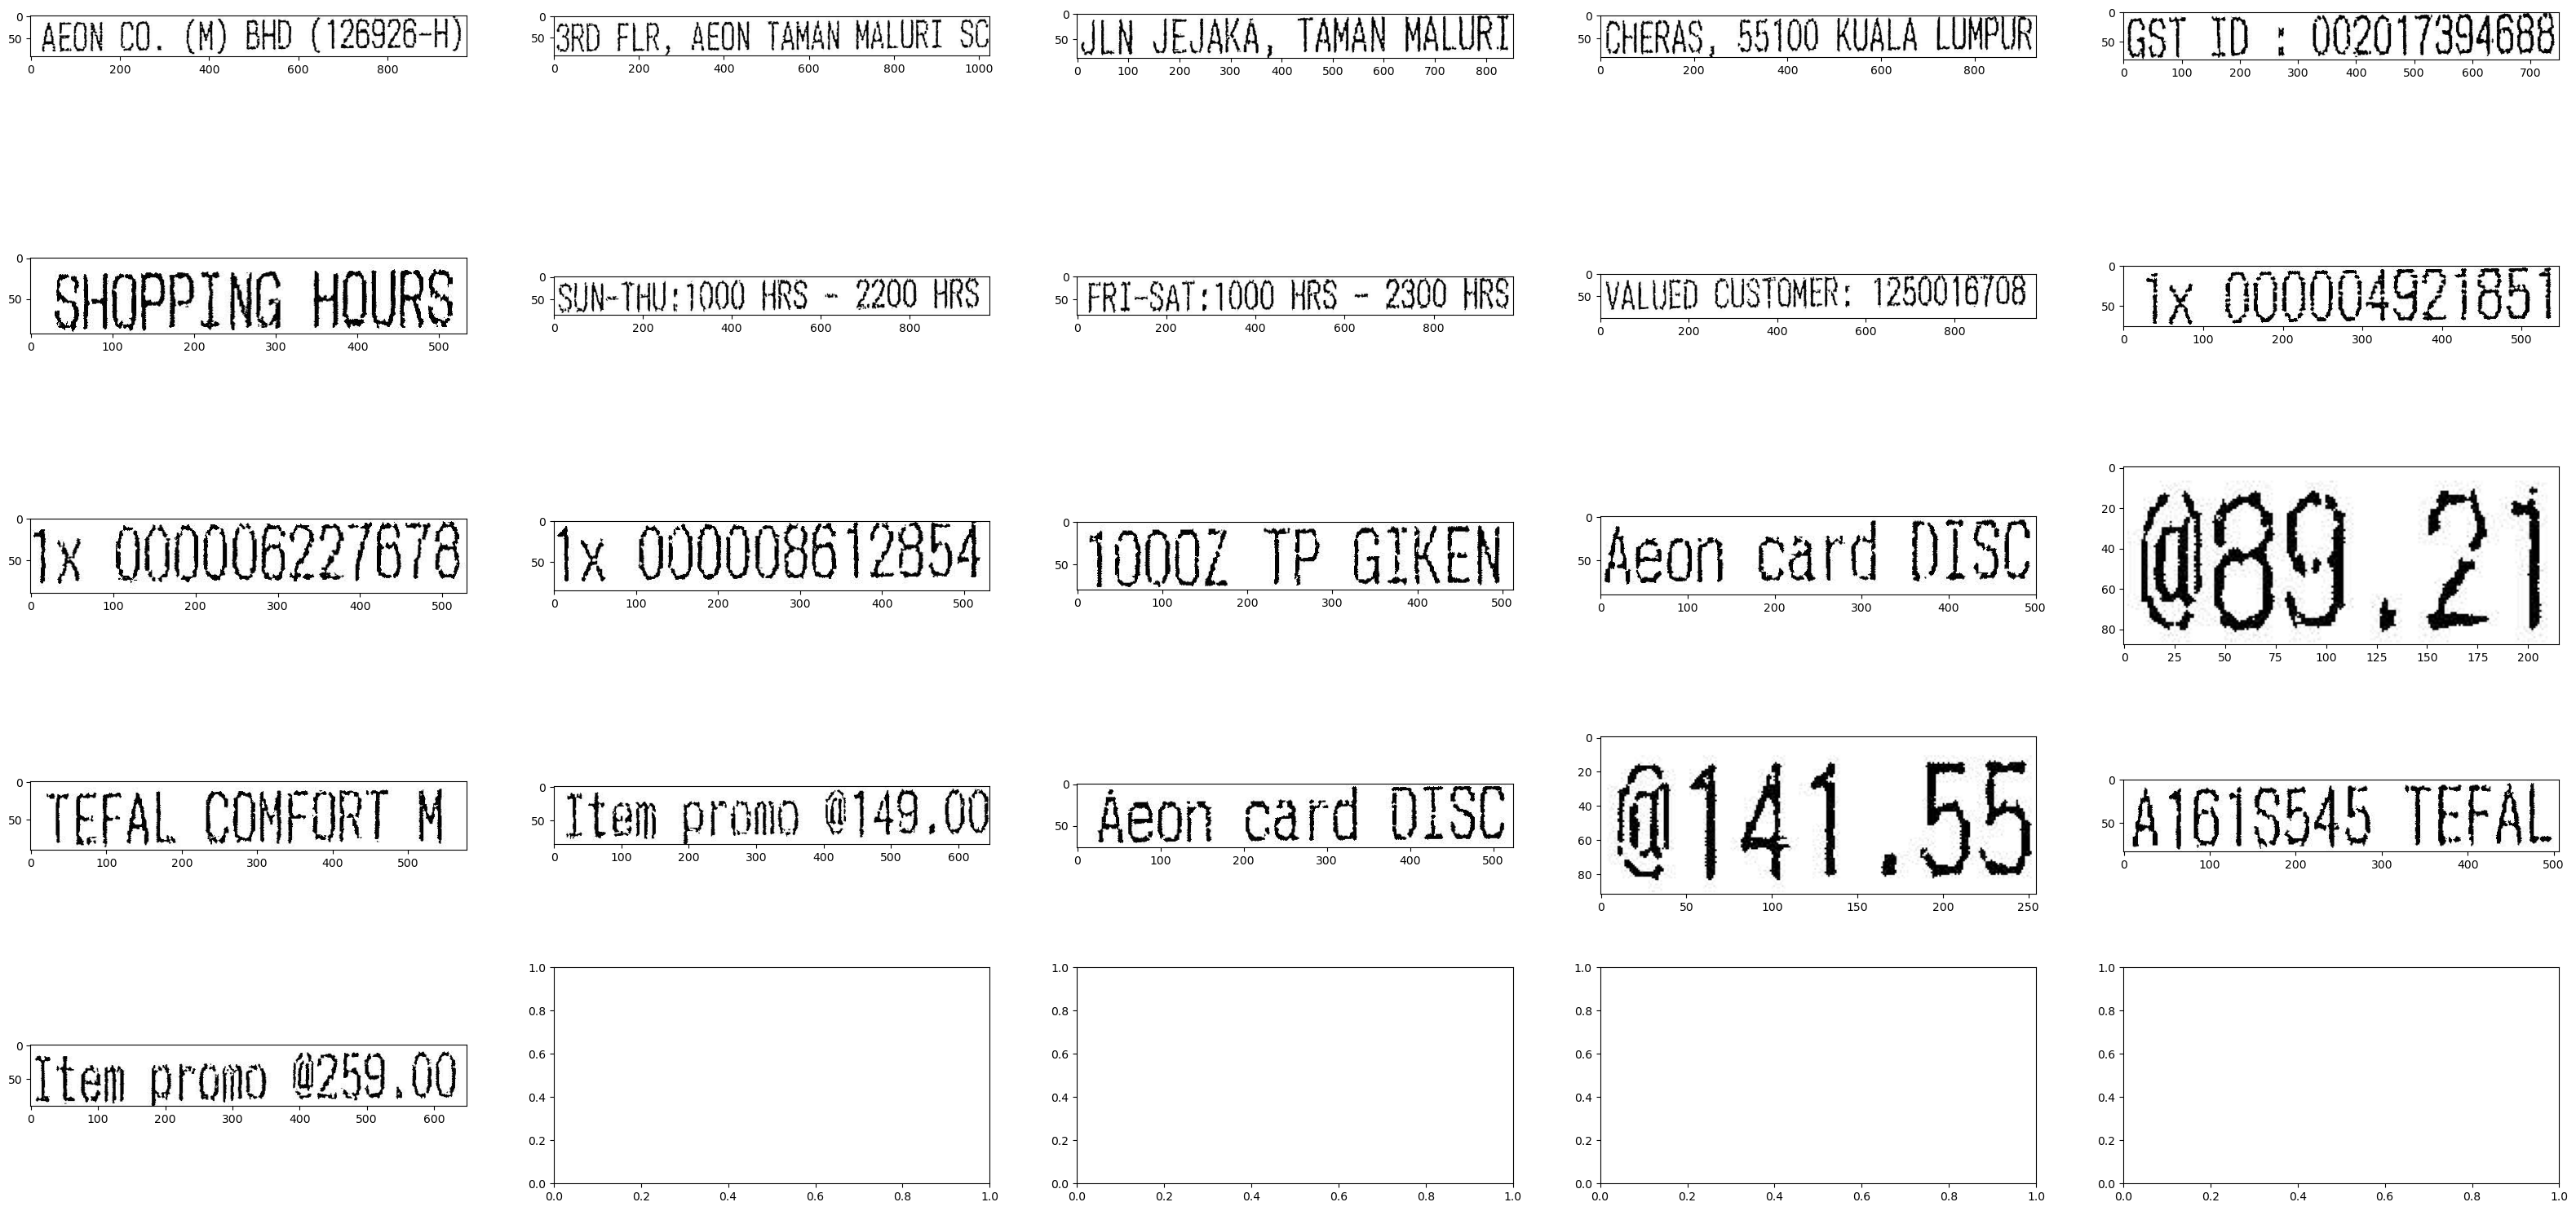

In [199]:
testfile = '00d0100894168'
img = cv2.imread(f'data/original/img/{testfile}.jpg')
imgdata = pd.read_csv(f"data/interim/ocr/{testfile}.csv")

fig, ax = plt.subplots(5,5,figsize=(40,20))
ctr = 0
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[int(row[1]['BB2']):int(row[1]['BB6'])+1, int(row[1]['BB1']):int(row[1]['BB3'])+1]
        if ctr < 25:
            ax[ctr//5][ctr%5].imshow(slc)
            ctr += 1
        if ctr == 21:
            break
fig.show()


75.52048500000001


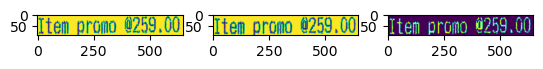

In [200]:
import pytesseract as pts

def clarity(slc, debug=False):
    """
    Returns the percentage of confidence, on average, tesseract has for each word
    """
    if debug: fig, ax = plt.subplots(1,3)
    slc2 = cv2.GaussianBlur(slc, (9,9), 1)
    slc2 = cv2.cvtColor(slc2, cv2.COLOR_BGR2GRAY)
    if debug: ax[0].imshow(slc2)
    text = pts.image_to_data(slc2, output_type='data.frame')
    slc3 = 255 - slc2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2))
    slc3 = cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
    slc3 = 255 - cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=0)
    slc3 = slc3.astype(np.uint8)
    if debug: ax[1].imshow(slc3)
    _, slc3 = cv2.threshold(slc3, 127, 255, cv2.THRESH_BINARY_INV)
    if debug: ax[2].imshow(slc3)
    text = pts.image_to_data(cv2.cvtColor(slc3, cv2.COLOR_BGR2RGB), output_type='data.frame', config="--psm 7")
    plt.imshow(slc3)
    text = text[text['text'].notna()]
    if len(text) == 0:
        return -1
    return sum(text['conf'])/len(text)

print(clarity(slc, debug=True))

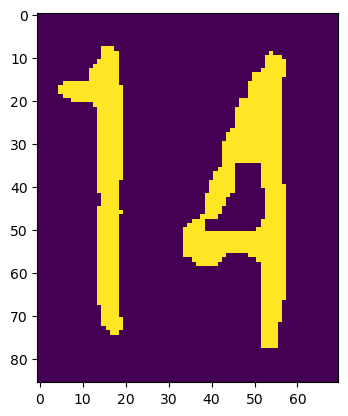

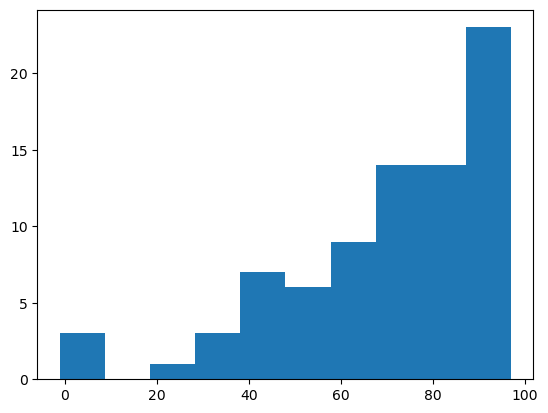

In [202]:
res = []
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[int(row[1]['BB2']):int(row[1]['BB6'])+1, int(row[1]['BB1']):int(row[1]['BB3'])+1]
        res.append(clarity(slc))
fig, ax = plt.subplots(1,1)
plt.hist(res)
plt.show()